In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [3]:
try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.1.0'



**A multilayer perceptron**

assuming $n$ layers, the output at layer $i$

$$\mathbf{a}_i = \text{activation}(\mathbf{a}_{i-1} \cdot \mathbf{W}_i + \mathbf{b}_i)$$

at the first layer

$$\mathbf{a}_0 = \text{activation}(\mathbf{X} \cdot \mathbf{W}_0 + \mathbf{b}_0)$$

and the layer prediction is the output of the last layer:

$$\hat{\mathbf{y}} = \mathbf{a}_{n-1}$$ 

with $\text{activation}$ being an activation function, such as $\text{sigmoid}(z) = \frac{1}{1+e^{-z}}$, $\text{tanh}$, $\text{ReLU}$, etc.


**Cost (with regularization)**


$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2 + \lambda \sum_{i=0}^{n-1} \bigg[ \| \mathbf{b}_i\|^2 + \|\mathbf{W}_i\|^2 \bigg]$$


$\lambda$ regulates the participation of the regularization terms. Given a vector or matrix $\mathbf{T}$, its squared norm is denoted by $||\mathbf{T}||^2 \in \mathbb{R}$ and it's computed by squaring all its elements and summing them all up. 


## Task 1: Multilayer perceptron model with low level API

build a custom model (`build`, `call`) using standard optimization (`model.compile`, etc.)

your class must:

- **include Tensorboard callbacks for BOTH LOSS AND ACCURACY. See the [example here](https://www.tensorflow.org/tensorboard/get_started)**. You will have to add the appropriate [keras metric](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) according to your model output.

- the `activations` parameter must be a list of strings containing one of `'sigmoid'`, `'tanh'`, `'linear'`, `'relu'` so that the corresponding `tf.keras.activations` function is used.

- create a **custom loss function** to include the regularization parameter and **use it when compiling the model**. Look in the internet for tutorials, for example [here](https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618), and many others




In [4]:
from tensorflow.keras.activations import relu, sigmoid, tanh, linear

In [20]:
from progressbar import progressbar as pbar
from tensorflow.keras import Model
from tensorflow.keras.activations import relu, sigmoid, tanh, linear

class MLP(Model):
    def __init__(self, neurons, activations, reg=0.):
        super(MLP, self).__init__()
        assert len(neurons)==len(activations), "must have the same number of neurons and activations"
        
        self.neurons = neurons
        self.reg = reg
        
        self.activation_map = {"linear": linear, "relu": relu, "tanh":tanh, "sigmoid": sigmoid}
        self.activations = [self.activation_map[i] for i in activations]
        
    def build(self, input_shape):
        
        self.W = []
        self.b = []

        last_n = input_shape[-1]
        for n in self.neurons:
            
            w = self.add_weight(shape=(last_n, n), initializer='random_normal', trainable=True, dtype=tf.float32)
            b = self.add_weight(shape=(n, ), initializer='random_normal', trainable=True, dtype=tf.float32)        
            
            self.W.append(w)
            self.b.append(b)
            last_n = n
        
    @tf.function
    def call(self, X):
        s = X
        for w,b,a in zip(self.W, self.b, self.activations):
            s = a(tf.matmul(s, w)+b)
        return s

    @tf.function
    def loss(self, y_true, y_pred):
        return tf.reduce_mean( (y_true-y_pred)**2 ) \
               + self.reg*tf.reduce_mean([tf.reduce_mean(i**2) for i in self.W+self.b])

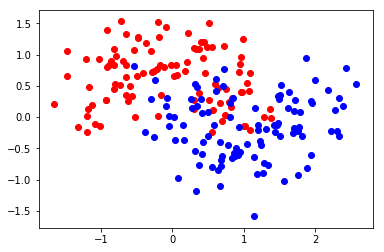

In [21]:
X, y = make_moons(200, noise=.35)
X, y = X.astype(np.float32), y.astype(np.float32).reshape(-1,1)
plt.scatter(X[:,0][y[:,0]==0], X[:,1][y[:,0]==0], color="red", label="class 0")
plt.scatter(X[:,0][y[:,0]==1], X[:,1][y[:,0]==1], color="blue", label="class 1")

In [22]:
!rm -rf logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/no_regularization")

mlp = MLP(neurons=[10,1], activations=["tanh","sigmoid"])
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=mlp.loss,
           metrics=[tf.keras.metrics.mae, tf.keras.metrics.binary_accuracy])

In [23]:
mlp.fit(X,y, epochs=400, batch_size=16, verbose=0, 
        callbacks=[tensorboard_callback])

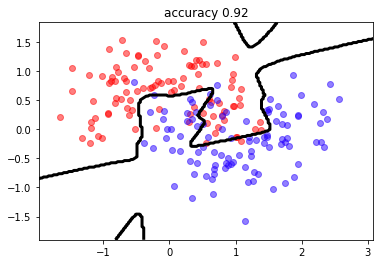

In [25]:
predict = lambda X: (mlp.predict(X)[:,0]>0.5).astype(int)
mlutils.plot_2Ddata_with_boundary(predict, X, y.reshape(-1));
plt.title("accuracy %.2f"%np.mean(predict(X)==y.reshape(-1)));

regularization must work!!!

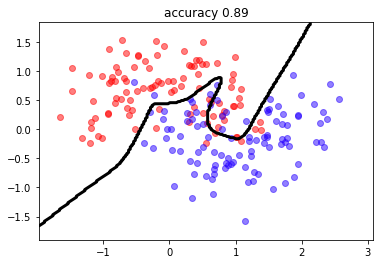

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/with_regularization")
mlp = MLP(neurons=[10,1], activations=["tanh","sigmoid"], reg=0.001)
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=mlp.loss,
            metrics=[tf.keras.metrics.mae, tf.keras.metrics.binary_accuracy])
mlp.fit(X,y, epochs=400, batch_size=10, verbose=0, callbacks=[tensorboard_callback])
mlutils.plot_2Ddata_with_boundary(predict, X, y.reshape(-1))
plt.title("accuracy %.2f"%np.mean(predict(X)==y.reshape(-1)));

In [412]:
%load_ext tensorboard
%tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Task 2: Multilayer perceptron model AND optimization loop with low level API

build a custom model sush as in the exercise above and implement your optimization loop in `.fit`
 
observe that you will have to:
- use whichever method you choose from the corresponding notebook (custom SGD, `apply_gradients`, `train_on_batch`)
- write by hand loss and accuracy to Tensorboard. See [`tf.summary`](https://www.tensorflow.org/api_docs/python/tf/summary)


In [45]:

class MLP(Model):
    def __init__(self, neurons, activations, reg=0.):
        super(MLP, self).__init__()
        assert len(neurons)==len(activations), "must have the same number of neurons and activations"
        
        self.neurons = neurons
        self.reg = reg
        
        self.activation_map = {"linear": linear, "relu": relu, "tanh":tanh, "sigmoid": sigmoid}
        self.activations = [self.activation_map[i] for i in activations]
        
    def build(self, input_shape):
        
        self.W = []
        self.b = []

        last_n = input_shape[-1]
        for n in self.neurons:
            
            w = self.add_weight(shape=(last_n, n), initializer='random_normal', trainable=True, dtype=tf.float32)
            b = self.add_weight(shape=(n, ), initializer='random_normal', trainable=True, dtype=tf.float32)        
            
            self.W.append(w)
            self.b.append(b)
            last_n = n
                
    @tf.function
    def call(self, X):
        s = X
        for w,b,a in zip(self.W, self.b, self.activations):
            s = a(tf.matmul(s, w)+b)
                        
        return s

    @tf.function
    def loss(self, y_true, y_pred):
        return tf.reduce_mean( (y_true-y_pred)**2 ) \
               + self.reg*tf.reduce_mean([tf.reduce_mean(i**2) for i in self.W+self.b])
    
    
    @tf.function
    def get_gradient(self, X, y):
        with tf.GradientTape() as t:
            loss = self.loss(y, self(X))

        return t.gradient(loss, self.W+self.b) 
    
    def fit(self, X, y, epochs, batch_size):
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]       
                self.train_on_batch(X_batch, y_batch)

In [46]:
mlp = MLP(neurons=[10,1], activations=["tanh","sigmoid"])
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=mlp.loss,
           metrics=[tf.keras.metrics.mae, tf.keras.metrics.binary_accuracy])

mlp.fit(X,y, epochs=400, batch_size=16)

100% (400 of 400) |######################| Elapsed Time: 0:00:06 Time:  0:00:06


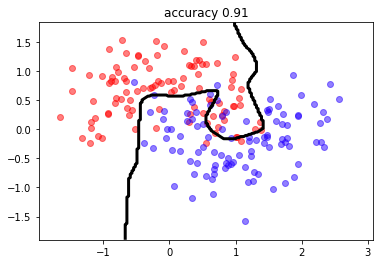

In [47]:
mlutils.plot_2Ddata_with_boundary(predict, X, y.reshape(-1));
plt.title("accuracy %.2f"%np.mean(predict(X)==y.reshape(-1)));

In [50]:
mlp = MLP(neurons=[10,1], activations=["tanh","sigmoid"], reg=0.01)
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=mlp.loss,
           metrics=[tf.keras.metrics.mae, tf.keras.metrics.binary_accuracy])

mlp.fit(X,y, epochs=400, batch_size=16)

100% (400 of 400) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


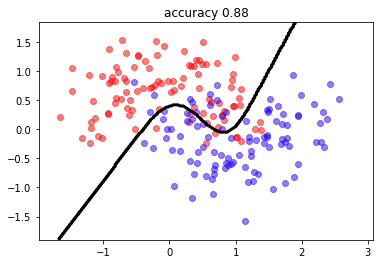

In [51]:
mlutils.plot_2Ddata_with_boundary(predict, X, y.reshape(-1));
plt.title("accuracy %.2f"%np.mean(predict(X)==y.reshape(-1)));